In [1]:
from sklearn.base import BaseEstimator, TransformerMixin
from typing import Any, Dict, Iterable, Iterator, List, Optional, Tuple, Union
import pandas as pd
import numpy as np
import tensorflow as tf
import mplfinance as mpf

import os

#Create folder, if exist pass exception
try:
    os.mkdir("Excel reports")
    os.mkdir("Saved models")
except:
    pass

excel_reports = ".\Excel reports"
saved_models = ".\Saved models"
ticker = 'aapl'

In [ ]:

####################################################################
from transformers import PullData

#Initiate parameters
window_size = 25
formation_window = 24
target_window = 4

GetData = PullData()

GetData.fit(ticker=ticker,
            start_date='2020-01-01',
            end_date='2022-08-17',
            interval='1wk',
            progress=False,
            condition=False,
            form_window=formation_window,
            target_window=target_window,
            timeperiod1=6,
            timeperiod2=12,
            timeperiod3=24,
            export_excel=True,
            excel_path = excel_reports
            )

data_prep = GetData.transform()
print("shape: ",data_prep.shape)

####################################################################

from transformers import NormalizeData

NormalizeData = NormalizeData()

NormalizeData.fit(window_size=25, shuffle=False, debug=False,export_excel = False, excel_path = excel_reports)

data_normalized, Dates = NormalizeData.transform(data_prep)

####################################################################

from training import SplitData

SplitData = SplitData()

SplitData.fit(split_ratio=0.8, window_size=25, dates=Dates, debug=True)

x_train, x_valid, x_train_x, x_valid_x = SplitData.transform(data_normalized)

In [18]:
#x_valid_new = x_valid.copy()

In [19]:
from training import GetTensoredDataset

GetTensoredDataset = GetTensoredDataset()

GetTensoredDataset.fit(window_size=25, batch_size=8, train=True, debug=False)

x_train_tensors, _ = GetTensoredDataset.transform(x_train)

x_train_tensors


Done


<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>

In [20]:
from training import GetTensoredDataset

GetTensoredValidDataset = GetTensoredDataset()

GetTensoredValidDataset.fit(
    window_size=25, batch_size=2, train=False, debug=False)

x_valid_tensors, labels = GetTensoredValidDataset.transform(x_valid)
x_valid_tensors


Done


<BatchDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

<b>Model Training</b>

In [21]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss', patience=6, mode='min', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=10e-15,
                              verbose=1)

model_checkpoint = ModelCheckpoint(monitor='val_loss',
                                   filepath=f'{saved_models}/{ticker}_80_model_checkpoint_recent.h5',
                                   save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]


def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true*y_pred, 0),
                    penalty * tf.square(y_true-y_pred),
                    tf.square(y_true - y_pred)
                    )

    return(tf.reduce_mean(loss, axis=-1))


tf.keras.losses.sign_penalty = sign_penalty


Model 1

In [22]:
# def ModelGeneral():
# #tf.random.set_seed(7788)

#     # model = tf.keras.models.Sequential([

#     #     tf.keras.layers.Conv1D(filters=256, kernel_size=10,
#     #                     strides=1, padding="same",
#     #                     activation=tf.nn.selu,
#     #                     input_shape=[None, 7]),
#     # #     tf.keras.layers.Conv1D(filters=512, kernel_size=10,
#     # #                       strides=1, padding="same",
#     # #                       activation=tf.nn.selu,
#     # #                       input_shape=[None, 7]),

#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     # tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Dense(1024, activation=tf.nn.selu),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Dense(1024, activation=tf.nn.selu),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Dense(1024, activation=tf.nn.selu),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Dense(1024, activation=tf.nn.selu),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Dense(16, activation=tf.nn.selu),
#     #     tf.keras.layers.Dense(16, activation=tf.nn.selu),
#     #     tf.keras.layers.Dense(4, activation=tf.nn.selu),
#     #     tf.keras.layers.Dense(3, activation=tf.nn.selu), #4
#     #     tf.keras.layers.Dense(1,activation=tf.nn.relu),
#     # ])

#     # #optimizer1 = tf.keras.optimizers.SGD(learning_rate=10e-7, momentum=0.9)
#     # #optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
#     # #optimizer3 = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False)
#     # #optimizer4 = tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07, name='Adadelta')

#     # optimizer5 = tf.keras.optimizers.Adagrad(learning_rate=0.0001, initial_accumulator_value=0.1, epsilon=1e-07,name='Adagrad')


#     # model.compile(loss=sign_penalty,
#     #             optimizer=optimizer5,
#     #             )

#     # model.fit(train_set, epochs=120,callbacks=[callbacks],validation_data=val_dataset)


Model 2

In [23]:
tf.random.set_seed(7788)
np.random.seed(7788)

model = tf.keras.models.Sequential([

    tf.keras.layers.Conv1D(filters=8, kernel_size=1,
                           strides=1, padding="same",
                           activation=tf.nn.selu,
                           input_shape=[None, 7]),
    tf.keras.layers.Conv1D(filters=16, kernel_size=1,
                           strides=1, padding="same",
                           activation=tf.nn.selu,
                           #input_shape=[None, 7]
                           ),
    tf.keras.layers.Conv1D(filters=32, kernel_size=10,
                           strides=1, padding="same",
                           activation=tf.nn.selu,
                           #input_shape=[None, 7]
                           ),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(9, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(9)),
    #tf.keras.layers.Dense(256, activation=tf.nn.selu),
    tf.keras.layers.Dense(4, activation=tf.nn.selu),
    # tf.keras.layers.Dense(4, activation=tf.nn.selu),
    # #tf.keras.layers.Dropout(0.99),
    #tf.keras.layers.Dense(3, activation=tf.nn.selu),
    # #tf.keras.layers.Dropout(0.99),
    tf.keras.layers.Dense(3, activation=tf.nn.selu),
    tf.keras.layers.Dense(2, activation=tf.nn.selu),        
    tf.keras.layers.Dense(1, activation=tf.nn.relu),
])

optimizer2 = tf.keras.optimizers.Adam(
    learning_rate=0.0009, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
optimizer5 = tf.keras.optimizers.Adagrad(
    learning_rate=0.005, initial_accumulator_value=5, epsilon=1e-07, name='Adagrad')

model.compile(loss=sign_penalty,
              optimizer=optimizer5,
              )

model.fit(x_train_tensors, epochs=1200, callbacks=[
          callbacks], validation_data=x_valid_tensors)


Epoch 1/1200
11/11 [==============================] - 14s 449ms/step - loss: 0.0213 - val_loss: 0.0628 - lr: 0.0050
Epoch 2/1200
11/11 [==============================] - 0s 39ms/step - loss: 0.0201 - val_loss: 0.0639 - lr: 0.0050
Epoch 3/1200
11/11 [==============================] - ETA: 0s - loss: 0.0193
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
11/11 [==============================] - 1s 54ms/step - loss: 0.0193 - val_loss: 0.0636 - lr: 0.0050
Epoch 4/1200
11/11 [==============================] - 1s 58ms/step - loss: 0.0179 - val_loss: 0.0631 - lr: 1.0000e-03
Epoch 5/1200
11/11 [==============================] - ETA: 0s - loss: 0.0178
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001999999862164259.
11/11 [==============================] - 1s 52ms/step - loss: 0.0178 - val_loss: 0.0628 - lr: 1.0000e-03
Epoch 6/1200
11/11 [==============================] - 1s 83ms/step - loss: 0.0176 - val_loss: 0.0627 - lr: 2.0000e-04
Epoch 7/1200
11/11 [==

In [24]:
def model_forecast(model, series, window_size, debug):
    """
    Get model, data and window size as an input. 
    Make prediction window is subtracted by 1, since we do not need label in window, 
    label value is skipped
    """
    c = 0

    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size-1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))

    if debug == True:
        # This block of code will print out data on which is made prediction
        for item in ds:
            c += 1
            if c < 3:
                print("\n"+str(c) + " prediction:\n ", item)
            else:
                break

    ds = ds.batch(1).prefetch(1)
    forecast = model.predict(ds)
    forecast2 = np.squeeze(forecast)
    return forecast2


forecast = model_forecast(model, x_valid, window_size=window_size, debug=False)
forecast[:2]


22/22 [==============================] - 2s 7ms/step


array([0.928256  , 0.93463975], dtype=float32)

In [25]:
# pr = x_valid.iloc[:24, :].to_numpy()
# pr = np.array([pr])
# pr = np.array([pr])
# pred = tf.data.Dataset.from_tensor_slices(pr)
# predict = model.predict(pred)
# print("Raw prediction: ", predict)


In [26]:
from transformers import ReverseNormalization

ReverseNormalization = ReverseNormalization()

ReverseNormalization.fit(forecasts=forecast, labels=labels,
                         x_valid=x_valid, x_valid_x=x_valid_x, window_size=25, debug=False)

df = ReverseNormalization.transform()
df.shape

Done


(550, 9)

In [27]:
from final_evaluation import GetFinalDataframe

GetFinalDataframe = GetFinalDataframe()

GetFinalDataframe.fit(dates=Dates,
                      x_valid=x_valid)

reversed_df = GetFinalDataframe.transform(df)
#df1.head(25)


Done


In [29]:
from final_evaluation import GetModelPerformance

GetModelPerformance = GetModelPerformance()

GetModelPerformance.fit(acceptance=0,
                        penalization=0,
                        entry_candle='Current Open',
                        budget=10000,
                        window_size=25,
                        export_excel=True,
                        excel_path = excel_reports)

trades_df = GetModelPerformance.transform(reversed_df)
#trades_df.shape


period: 2021-09-06 - 2022-07-11
Formations:  22
Entry Candle:  Current Open

Total Trades:  22
Profit Trades:  11
Loss Trades:  11

Win Ratio: 50.0 %
Loss Ratio: 50 %

Average profit per trade:  480

Gross profit:  10565
Gross loss:  -7339

Net profit:  3226


In [31]:
trade = 1
budget = 10000
entry_candle = 'Current Open'
#trades_df.head(25)

Trade:  1
Period: 2021-09-06 - 2022-02-14

Budget:  10000

Entry price:  164.98
Label (target):  168.91
Model prediction:  179.74
Market Change: -1.0 $
Profit: -60.61 $


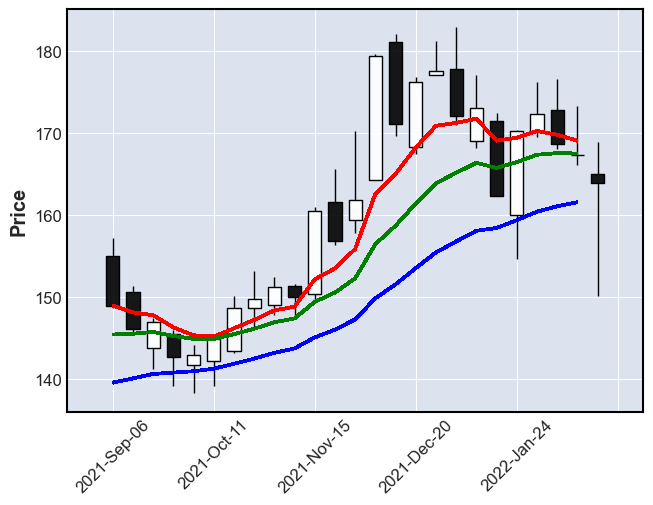

In [32]:
#trade = 232

def PlotTrade(trade=trade, trades_df=trades_df):
    Dates = trades_df['Datetime']

    print("Trade: ", trade)

    selected_df = trades_df[trades_df['trade'] == trade]

    # Get EMAs
    dates = selected_df['Datetime']
    ema6 = selected_df['EMA6']
    ema6 = ema6[:-1]
    ema12 = selected_df['EMA12']
    ema12 = ema12[:-1]
    ema24 = selected_df['EMA24']
    ema24 = ema24[:-1]

    datepairs_ema6 = [(d1, d2) for d1, d2 in zip(dates, ema6)]
    datepairs_ema12 = [(d1, d2) for d1, d2 in zip(dates, ema12)]
    datepairs_ema24 = [(d1, d2) for d1, d2 in zip(dates, ema24)]

    # #Format Dataframe
    quotes = selected_df.iloc[:, :10]
    quotes['Datetime'] = quotes['Datetime'].astype('datetime64')
    quotes = quotes.set_index('Datetime')
    quotes = quotes.iloc[:, :4]
    quotes.columns = ['open', 'high', 'low', 'close']

    # Define function to get entry
    EntryPriceRow = 0

    def GetEntryPriceColl(candle):
        if candle == 'Previous High':
            EntryPriceColl = 1
            EntryPriceRow = 1
        if candle == 'Current Open':
            EntryPriceColl = 0
            EntryPriceRow = 0
        if candle == 'Previous Close':
            EntryPriceColl = 3
            EntryPriceRow = 1
        return EntryPriceColl, EntryPriceRow

    entry_price_column, entry_price_row = GetEntryPriceColl(entry_candle)  #
    # budget = 10000

    entry = selected_df.iloc[window_size-1-entry_price_row, entry_price_column]
    profit = round(selected_df.iloc[window_size-1, 10], 2)
    real_profit = round((budget / entry)*profit, 2)
    print(f"Period: {selected_df.iloc[0,9]} - {selected_df.iloc[window_size-2,9]}")
    print("\nBudget: ", budget)

    print("\nEntry price: ", round(entry, 2))
    print("Label (target): ", round(selected_df.iloc[window_size-1, 7], 2))
    print("Model prediction: ", round(selected_df.iloc[window_size-1, 8], 2))
    print(
        f"Market Change: {round(selected_df.iloc[window_size-1, 10], 2)} $")
    print(f"Profit: {real_profit} $")

    mpf.plot(quotes, type='candle', alines=dict(alines=[datepairs_ema6, datepairs_ema12, datepairs_ema24], colors=[
        'r', 'g', 'b']))  # datepairs_ema12,datepairs_ema24

    return selected_df


df = PlotTrade(trade=trade)
trade += 1
#df


In [33]:
from final_evaluation import GetPerformanceReport

GetPerformanceReport = GetPerformanceReport()

GetPerformanceReport.fit(entry_candle="Current Open",
                        budget=10000,
                        window_size=25,
                        export_excel=True,
                        excel_path = excel_reports)

trades_df_final = GetPerformanceReport.transform(trades_df)
trades_df_final


Done


,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,Datetime,profit,trade,Entry,Performance
0,154.970001,157.259995,148.699997,148.970001,148.978732,145.446614,139.562798,nn,nn,2021-09-06,-1.000000,1,nn,nn
1,150.630005,151.419998,145.759995,146.059998,148.144808,145.540981,140.082574,nn,nn,2021-09-13,-1.000000,1,nn,nn
2,143.800003,147.470001,141.270004,146.919998,147.794862,145.753137,140.629568,nn,nn,2021-09-20,-1.000000,1,nn,nn
3,145.470001,145.960007,139.110001,142.649994,146.324900,145.275730,140.791202,nn,nn,2021-09-27,-1.000000,1,nn,nn
4,141.759995,144.220001,138.270004,142.899994,145.346355,144.910233,140.959905,nn,nn,2021-10-04,-1.000000,1,nn,nn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,133.419998,141.910004,133.320007,141.660004,141.834333,147.788278,153.248825,nn,nn,2022-06-20,11.111238,22,nn,nn
546,142.699997,143.490005,133.770004,138.929993,141.004521,146.425465,152.103319,nn,nn,2022-06-27,11.111238,22,nn,nn
547,137.770004,147.550003,136.929993,147.039993,142.728942,146.520008,151.698253,nn,nn,2022-07-04,11.111238,22,nn,nn
548,145.669998,150.860001,142.119995,150.169998,144.854958,147.081545,151.575992,nn,nn,2022-07-11,11.111238,22,nn,nn


In [4]:
#import tensorflow as tf
from final_evaluation import MakeSinglePrediction

MakeSinglePrediction = MakeSinglePrediction()

fit_output = MakeSinglePrediction.fit(
                        model_name=f'{saved_models}/{ticker}_80_model_checkpoint_recent.h5',
                        form_window=24,
                        ticker='aapl',
                        start_date="2021-03-18",
                        end_date="2022-08-13",
                        interval='1wk',
                        progress=False,
                        condition=False,
                        timeperiod1=6,
                        timeperiod2=12,
                        timeperiod3=24,
                        debug=False,
                        budget=10000,
                        penalization=0,
                        acceptance=0,
                        entry_candle='Current Close')

#fit method outputs tuple, get only trade formation out of tuple
trade_formation = fit_output[1]

###IMPORTANT!!!!
#trade_formation dataframe must be checked before transformation, sometimes df pulled via yahoo finance 
# is shifted, and trade formation does not have entire formation in itself. in this case there must 
# be changed end_date in fit method

MakeSinglePrediction.transform(trade_formation)



1/1 [==============================] - 2s 2s/step

Entry candle (Current Close)

Prediction is NOT profitable

Entry price:  172.1
Max Prediction:  169.39


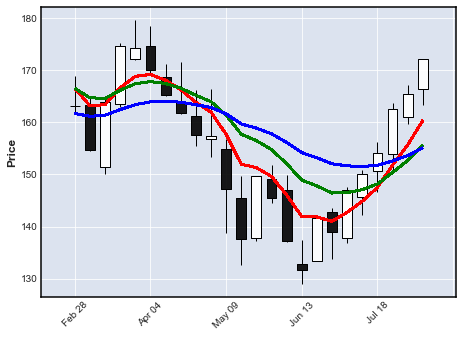

In [3]:
import mplfinance as mpf

def PlotChart(trade_formation=trade_formation):
    
    selected_df = trade_formation.reset_index()

    #Get EMAs
    dates = selected_df['Date']

    #Get EMAs
    dates = selected_df['Date']
    ema6 = selected_df['EMA6']
    ema12 = selected_df['EMA12']
    ema24 = selected_df['EMA24']

    datepairs_ema6 = [(d1,d2) for d1,d2 in zip(dates,ema6)]
    datepairs_ema12 = [(d1,d2) for d1,d2 in zip(dates,ema12)]
    datepairs_ema24 = [(d1,d2) for d1,d2 in zip(dates,ema24)]

    #Format Dataframe
    quotes = selected_df.iloc[:,:10]
    quotes['Date'] = quotes['Date'].astype('datetime64')
    quotes = quotes.set_index('Date')

    try: 
        quotes = quotes.drop('index',axis=1)
    except:
        pass
    
    #Plot
    quotes = quotes.iloc[:,:8]
    quotes.columns=['open','high','low','close','ema6','ema12','ema24']
    #Plot Chart
    mpf.plot(quotes,type='candle',alines=dict(alines=[datepairs_ema6,datepairs_ema12,datepairs_ema24],colors=['r','g','b']))

PlotChart(trade_formation)